<a href="https://colab.research.google.com/gist/matthen/e76dccc14f37e7e584ff0ea3371e1f4a/polyai-encoder-tfhub.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# The PolyAI Encoder

This notebook demonstrates how to use the PolyAI Encoder model, to encode sentences to a meaningful semantic space, and to rank responses in a conversation.

# Install dependencies

The encoder model requires the subword tokenization ops from the [tensorflow.text](https://github.com/tensorflow/text) module to run. This is released for tensorflow 2.0 and 1.14. In this colab we opt for tf 1.14.

In [0]:
!pip install tensorflow-gpu==1.14.0
!pip install --no-deps tensorflow_text==0.1.0

In [0]:
# Import the required dependencies

import tensorflow_hub as tfhub
import tensorflow as tf
import tensorflow_text  # required for tokenization ops

sess = None

assert tf.__version__ == "1.14.0", (
    f"found tf version {tf.__version__}, but need 1.14.0")
assert tf.test.is_gpu_available(), (
    "GPU not available. please use a GPU runtime")

# Computing sentence encodings

The default signature for the encoder model encodes sentences to a meaningful semantic space. Sentences can be compared for semantic similarity in this space, and NLP classifiers can be trained on top of these encodings.

This section demonstrates encoding texts with the encoder, and computing similarities.

In [3]:
# Load the tensorflow hub module into a fresh session.

if sess is not None:
    sess.close()

sess = tf.InteractiveSession(graph=tf.Graph())

module = tfhub.Module("http://models.poly-ai.com/encoder/v1/model.tar.gz")

text_placeholder = tf.placeholder(dtype=tf.string, shape=[None])
encoding_tensor = module(text_placeholder)
encoding_dim = int(encoding_tensor.shape[1])
print(f"encoder encodes text to {encoding_dim}-dimensional vectors")

sess.run(tf.tables_initializer())
sess.run(tf.global_variables_initializer())


def encode(texts):
    """Encode the given texts to the encoding space."""
    return sess.run(encoding_tensor, feed_dict={text_placeholder: texts})

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


encoder encodes text to 1024-dimensional vectors


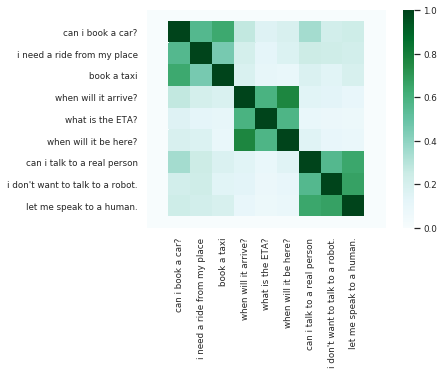

In [97]:
# Compute the similarity between a collection of sentences.

import numpy as np
from sklearn.metrics import pairwise
import seaborn

texts = [
         # booking a ride
         "can i book a car?",
         "i need a ride from my place",
         "book a taxi",

         # asking for ETA
         "when will it arrive?",
         "what is the ETA?",
         "when will it be here?",

         # asking to talk to a human
         "can i talk to a real person",
         "i don't want to talk to a robot.",
         "let me speak to a human.",
]

# Pad with "" to make heatmap display better.
texts = [""] + texts + [""]

encodings = encode(texts)

similarities = pairwise.cosine_similarity(encodings)
seaborn.set(font_scale=0.8)
g = seaborn.heatmap(
    similarities,
    xticklabels=texts,
    yticklabels=texts,
    vmin=0.,
    vmax=1.,
    cmap="BuGn",
    square=True,
)

# Response Ranking

The PolyAI encoder is trained on the response ranking task, so it can be used to find good responses to a given conversational context.

This section demonstrates how to rank responses, by computing cosine similarities of context and response representations in the shared response ranking space. Response representations for a fixed candidate list are first pre-computed. When a new context is provided, it is encoded and then compared to the pre-computed response representations.

In [9]:
if sess is not None:
    sess.close()

sess = tf.InteractiveSession(graph=tf.Graph())

module = tfhub.Module("http://models.poly-ai.com/encoder/v1/model.tar.gz")

text_placeholder = tf.placeholder(dtype=tf.string, shape=[None])
context_encoding_tensor = module(text_placeholder, signature="encode_context")
response_encoding_tensor = module(text_placeholder, signature="encode_response")

encoding_dim = int(context_encoding_tensor.shape[1])
print(f"encoder encodes contexts & responses to {encoding_dim}-dimensional vectors")

sess.run(tf.tables_initializer())
sess.run(tf.global_variables_initializer())

def encode_contexts(texts):
    return sess.run(context_encoding_tensor, feed_dict={text_placeholder: text})

def encode_responses(texts):
    return sess.run(response_encoding_tensor, feed_dict={text_placeholder: texts})

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


encoder encodes contexts & responses to 512-dimensional vectors


In [19]:
# Pre-encode responses.
# Download a file of random facts to serve as candidate responses for the demo.
!wget -q https://raw.githubusercontent.com/assaf/dailyhi/master/facts.txt -O facts.txt

import numpy as np

responses = []
with open("facts.txt") as f:
    for line in f:
        responses.append(line.strip())

# Encode the responses in batches of 64.
batch_size = 64
response_encodings = []
for i in range(0, len(responses), batch_size):
    batch = responses[i:i + batch_size]
    response_encodings.append(encode_responses(batch))

response_encodings = np.concatenate(response_encodings)
print(f"Encoded {response_encodings.shape[0]} candidate responses.")

Encoded 3090 candidate responses.


In [59]:
#@title Rank responses { run: "auto" }
#@markdown Find the best response in a list of around 3 thousand random facts. 
context = "tell me something interesting about birds" # @param
context_encoding = encode_contexts([context])
scores = np.dot(response_encodings, context_encoding.T)
top_index = np.argmax(scores)
top_score = float(scores[top_index])
print(f"[{top_score:.3f}] {responses[top_index]}")

[0.417] The oldest bird on record was Cocky, a cockatoo, who died in the London Zoo at the age of 82
